Week of 4/21

In [34]:
import json
#from google.colab import drive

# Get the notebook's filename (usually matches the GitHub repo name)
!ls *.ipynb
notebook_name = "NLPProject.ipynb"  # ← Replace with your filename

# Load and fix the notebook
with open(notebook_name, 'r') as f:
    nb = json.load(f)

# Option A: Remove widgets metadata completely (recommended)
if 'metadata' in nb and 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

# Option B: Or add the missing state key
# if 'metadata' in nb and 'widgets' in nb['metadata']:
#     nb['metadata']['widgets']['state'] = {}

# Save the fixed version
with open(notebook_name, 'w') as f:
    json.dump(nb, f)

print("Notebook metadata fixed! You can now commit to GitHub.")

Notebook metadata fixed! You can now commit to GitHub.


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [35]:
from pprint import pprint
from operator import itemgetter
import nltk
from nltk.corpus import framenet as fn
from nltk.corpus.reader.framenet import PrettyList
nltk.download('framenet_v17')

[nltk_data] Downloading package framenet_v17 to
[nltk_data]     C:\Users\ogboi\AppData\Roaming\nltk_data...
[nltk_data]   Package framenet_v17 is already up-to-date!


True

In [36]:
frames_with_time_ex = {}
for f in fn.frames():
    for x in f.FE:
        if x == "Time":
            frames_with_time_ex[f.name] = f

In [37]:
def align_labels_with_tokens(text, char_labels, offsets):
    token_labels = []
    for start, end in offsets:
        if start == end:
            token_labels.append("O")  # Special tokens like [CLS], [SEP]
        else:
            # Majority vote over character labels inside the token span
            span_labels = char_labels[start:end]
            if all(lab == "O" for lab in span_labels):
                token_labels.append("O")
            elif span_labels[0] == "B-Time":
                token_labels.append("B-Time")
            else:
                token_labels.append("I-Time")
    return token_labels


In [38]:
import torch
from nltk.corpus import framenet as fn
from transformers import BertTokenizerFast

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Map BIO tags to IDs
label2id = {"O": 0, "B-Time": 1, "I-Time": 2}
input_ids_list = []
attention_masks_list = []
labels_list = []

# Find frames that include "Time" as a frame element

for name, frame in frames_with_time_ex.items():
    # Print the frame name for reference
    for lu in frame.lexUnit.values():
        #print(f"\nLexical Unit: {lu['name']}")
        lu_data = fn.lu(lu['ID'])
        for ex in lu_data['exemplars']:
            text = ex['text']
            char_labels = ["O"] * len(text)
            has_time_fe = False

            for fe in ex['FE']:
                for i in fe:
                    if i[2] == "Time":
                        start, end = i[0], i[1]
                        if start < end:
                            char_labels[start] = "B-Time"
                            for i in range(start+1, end):
                                char_labels[i] = "I-Time"
                            has_time_fe = True
            if not has_time_fe:
                continue


            # Tokenize
            tokenized = tokenizer(text, return_offsets_mapping=True, truncation=True, padding="max_length", max_length=128)
            input_ids = tokenized["input_ids"]
            attention_mask = tokenized["attention_mask"]
            offsets = tokenized["offset_mapping"]

            # Map character-level labels to token-level labels
            token_labels = align_labels_with_tokens(text, char_labels, offsets)
            label2id_binary = {"O": 0, "B-Time": 1, "I-Time": 2}  # Map both B-Time to 1 and I to 2
            # Pad remaining labels with -100 where attention mask is 0 (i.e., padding tokens)


            label_ids = [label2id_binary.get(lab, 0) for lab in token_labels]
            label_ids = [
                label if mask == 1 else -100 
                for label, mask in zip(label_ids, attention_mask)
            ]
            # Store tensors
            input_ids_list.append(torch.tensor(input_ids))
            attention_masks_list.append(torch.tensor(attention_mask))
            labels_list.append(torch.tensor(label_ids))

# Final dataset tensors
input_ids_tensor = torch.stack(input_ids_list)
attention_masks_tensor = torch.stack(attention_masks_list)
labels_tensor = torch.stack(labels_list)

print("Tensor shapes:")
print("Input IDs:", input_ids_tensor.shape)
print("Attention Masks:", attention_masks_tensor.shape)
print("Labels:", labels_tensor.shape)

Tensor shapes:
Input IDs: torch.Size([9013, 128])
Attention Masks: torch.Size([9013, 128])
Labels: torch.Size([9013, 128])


In [39]:
indices = (labels_tensor == 1).nonzero(as_tuple=False)
sample_idx, token_idx = indices[0].tolist()
token_id = input_ids_tensor[sample_idx][token_idx]
token = tokenizer.convert_ids_to_tokens([token_id])[0]
print(f"Token: {token}")

Token: when


In [40]:
tokens = tokenizer.convert_ids_to_tokens(input_ids_tensor[sample_idx])
print("Tokens:", tokens)

Tokens: ['[CLS]', 'she', 'had', 'seen', 'no', 'reason', 'to', 'abandon', 'it', 'when', 'she', 'came', 'to', 'med', '##ew', '##ich', 'two', 'years', 'ago', ',', 'even', 'though', 'she', 'might', 'now', 'have', 'been', 'able', 'to', 'afford', 'a', 'car', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

In [41]:
labels = labels_tensor[sample_idx]
for tok, label in zip(tokens, labels):
    print(f"{tok:15} -> {label.item()}")

[CLS]           -> 0
she             -> 0
had             -> 0
seen            -> 0
no              -> 0
reason          -> 0
to              -> 0
abandon         -> 0
it              -> 0
when            -> 1
she             -> 2
came            -> 2
to              -> 2
med             -> 2
##ew            -> 2
##ich           -> 2
two             -> 2
years           -> 2
ago             -> 2
,               -> 0
even            -> 0
though          -> 0
she             -> 0
might           -> 0
now             -> 0
have            -> 0
been            -> 0
able            -> 0
to              -> 0
afford          -> 0
a               -> 0
car             -> 0
.               -> 0
[SEP]           -> 0
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -10

In [42]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(input_ids_tensor, attention_masks_tensor, labels_tensor)


In [43]:
from torch.utils.data import DataLoader, RandomSampler, SubsetRandomSampler
from torch.utils.data import random_split
# Parameters
batch_size = 5
validation_split = 0.5

train_size = int((1 - validation_split) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),  # Shuffle the data
    batch_size=batch_size
)

# Create DataLoader for validation (without shuffling)
val_dataloader = DataLoader(
    val_dataset,
    sampler=SubsetRandomSampler(range(len(val_dataset))),  # Don't shuffle validation data
    batch_size=batch_size
)

In [44]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

class FrameElementClassifier(nn.Module):
    def __init__(self, bert_model='bert-base-uncased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        #self.query_encoder = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.token_projection = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
        self.dropout = nn.Dropout(0.1)

    #def forward(self, input_ids, attention_mask, role_ids, role_mask):
    def forward(self, input_ids, attention_mask):
        # Encode sentence
        sentence_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_embeddings = sentence_outputs.last_hidden_state  # shape: (B, T, H)

        # Project sentence tokens
        token_embeddings = self.token_projection(token_embeddings)  # shape: (B, T, H)
        logits = self.classifier(token_embeddings)

        return logits  # Apply softmax for inference or use with CrossEntropyLoss

In [45]:
num_epochs = 20
accuracies = []
num_batches = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FrameElementClassifier().to(device)
#class_weights = torch.tensor([0.4, 0.6]).to(device)  # Make Time more important
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions_batch = 0
    total_predictions = 0
    
    # Training loop
    for i, batch in enumerate(train_dataloader):
        if i >= num_batches:
            break
        print(i)
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]
        
        optimizer.zero_grad()
        
        probs = model(input_ids, attention_mask)
        loss = loss_fn(probs.view(-1, 3), target_index.view(-1))
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [46]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions_batch = 0
    total_predictions = 0
    
    # Training loop
    for i, batch in enumerate(train_dataloader):
        if i >= num_batches:
            break
        print(i)
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]
        
        optimizer.zero_grad()
        
        probs = model(input_ids, attention_mask)
        loss = loss_fn(probs.view(-1, 3), target_index.view(-1))
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [47]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]

        logits = model(input_ids, attention_mask)
        predicted_tokens = torch.argmax(logits, dim=-1)

        mask = (target_index != -100)

        all_true_labels.extend(target_index[mask].view(-1).cpu().numpy())
        all_pred_labels.extend(predicted_tokens[mask].view(-1).cpu().numpy())

# Report
print("Classification Report (O, B-Time, I-Time):")
print(classification_report(all_true_labels, all_pred_labels, target_names=['O', 'B-Time', 'I-Time']))

print("Confusion Matrix:")
cm = confusion_matrix(all_true_labels, all_pred_labels)
print(cm)


Classification Report (O, B-Time, I-Time):
              precision    recall  f1-score   support

           O       0.99      0.96      0.98      1864
      B-Time       0.76      0.89      0.82        76
      I-Time       0.76      0.96      0.84       205

    accuracy                           0.96      2145
   macro avg       0.84      0.94      0.88      2145
weighted avg       0.96      0.96      0.96      2145

Confusion Matrix:
[[1786   20   58]
 [   3   68    5]
 [   8    1  196]]


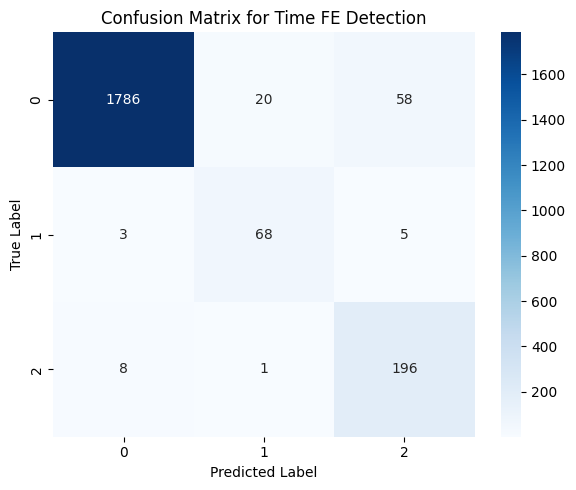

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Time FE Detection')
plt.tight_layout()
plt.show()

In [49]:
import numpy as np

true_np = np.array(all_true_labels)
pred_np = np.array(all_pred_labels)

for label_id, label_name in enumerate(['O', 'B-Time', 'I-Time']):
    total = np.sum(true_np == label_id)
    correct = np.sum((true_np == label_id) & (pred_np == label_id))
    print(f"{label_name} Accuracy: {correct}/{total} = {correct/total:.4f}")


O Accuracy: 1786/1864 = 0.9582
B-Time Accuracy: 68/76 = 0.8947
I-Time Accuracy: 196/205 = 0.9561


In [50]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch import CRF

class FrameElementClassifier2(nn.Module):
    def __init__(self, bert_model='bert-base-uncased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        #self.query_encoder = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.token_projection = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
        #increase dropout
        self.dropout = nn.Dropout(0.3)
        #reduce overfitting
        self.layernorm = nn.LayerNorm(self.bert.config.hidden_size)

    #def forward(self, input_ids, attention_mask, role_ids, role_mask):
    def forward(self, input_ids, attention_mask):
        # Encode sentence
        sentence_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_embeddings = sentence_outputs.last_hidden_state  # shape: (B, T, H)

        # Project sentence tokens
        token_embeddings = self.token_projection(token_embeddings)  # shape: (B, T, H)
        logits = self.classifier(token_embeddings)

        return logits  # Apply softmax for inference or use with CrossEntropyLoss

ImportError: cannot import name 'CRF' from 'torch' (c:\Users\ogboi\NLPProject\myenv\Lib\site-packages\torch\__init__.py)

In [ ]:
num_epochs = 20
accuracies = []
num_batches = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = FrameElementClassifier2().to(device)
#class_weights = torch.tensor([0.4, 0.6]).to(device)  # Make Time more important
weights = torch.tensor([1.0, 5.0, 3.0]).to(device)
loss_fn2 = nn.CrossEntropyLoss(weight = weights, ignore_index=-100)
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=2e-5)

for epoch in range(num_epochs):
    model2.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions_batch = 0
    total_predictions = 0
    
    # Training loop
    for i, batch in enumerate(train_dataloader):
        if i >= num_batches:
            break
        print(i)
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]
        
        optimizer2.zero_grad()
        
        probs = model2(input_ids, attention_mask)
        loss = loss_fn2(probs.view(-1, 3), target_index.view(-1))
        
        loss.backward()
        optimizer2.step()

        running_loss += loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model2.eval()
all_true_labels2 = []
all_pred_labels2 = []

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]

        logits = model2(input_ids, attention_mask)
        predicted_tokens = torch.argmax(logits, dim=-1)
        

        mask = (target_index != -100)

        all_true_labels2.extend(target_index[mask].view(-1).cpu().numpy())
        all_pred_labels2.extend(predicted_tokens[mask].view(-1).cpu().numpy())

# Report
print("Classification Report (O, B-Time, I-Time):")
print(classification_report(all_true_labels2, all_pred_labels2, target_names=['O', 'B-Time', 'I-Time']))

print("Confusion Matrix:")
cm2 = confusion_matrix(all_true_labels2, all_pred_labels2)
print(cm2)

Classification Report (O, B-Time, I-Time):
              precision    recall  f1-score   support

           O       0.98      0.91      0.95      1949
      B-Time       0.61      0.93      0.74        76
      I-Time       0.52      0.81      0.64       183

    accuracy                           0.90      2208
   macro avg       0.71      0.88      0.77      2208
weighted avg       0.93      0.90      0.91      2208

Confusion Matrix:
[[1777   41  131]
 [   2   71    3]
 [  31    4  148]]


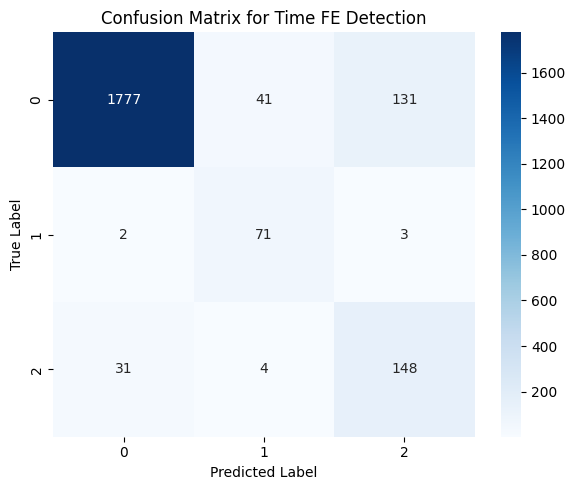

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Time FE Detection')
plt.tight_layout()
plt.show()

In [ ]:
model2.eval()
num_examples_to_print = 1  # or however many you want
examples_printed = 0

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]
        probs = model(input_ids, attention_mask)
        preds = torch.argmax(torch.softmax(probs, dim=-1), dim=-1)

        for j in range(input_ids.size(0)):
            if examples_printed >= num_examples_to_print:
                break

            input_id = input_ids[j]
            attention = attention_mask[j]
            pred = preds[j]
            label = target_index[j]

            # Only consider real (non-padding) tokens
            mask = (attention == 1) & (label != -100)
            input_id = input_id[mask]
            pred = pred[mask]
            label = label[mask]

            tokens = tokenizer.convert_ids_to_tokens(input_id)
            sentence = tokenizer.convert_tokens_to_string(tokens)

            print(f"\n🔹 Sentence {examples_printed + 1}:")
            print(f"   Text: {sentence}")
            print(f"   Tokens: {tokens}")
            print(f"   True Labels:     {label.tolist()}")
            print(f"   Predicted Labels:{pred.tolist()}")

            # Optional: highlight mismatches
            print("   Comparison:")
            for tok, gold, guess in zip(tokens, label.tolist(), pred.tolist()):
                status = "✅" if gold == guess else "❌"
                print(f"     {tok:15} | True: {gold} | Pred: {guess} {status}")

            examples_printed += 1



🔹 Sentence 1:
   Text: [CLS] " when we saw the compound where the brothers lived, we were shocked by what we saw, " the official said. [SEP]
   Tokens: ['[CLS]', '"', 'when', 'we', 'saw', 'the', 'compound', 'where', 'the', 'brothers', 'lived', ',', 'we', 'were', 'shocked', 'by', 'what', 'we', 'saw', ',', '"', 'the', 'official', 'said', '.', '[SEP]']
   True Labels:     [0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   Predicted Labels:[0, 0, 1, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   Comparison:
     [CLS]           | True: 0 | Pred: 0 ✅
     "               | True: 0 | Pred: 0 ✅
     when            | True: 1 | Pred: 1 ✅
     we              | True: 2 | Pred: 2 ✅
     saw             | True: 2 | Pred: 2 ✅
     the             | True: 2 | Pred: 2 ✅
     compound        | True: 2 | Pred: 0 ❌
     where           | True: 2 | Pred: 0 ❌
     the             | True: 2 | Pred: 2 ✅
     brothers        | True: 2 | Pred: 2 ✅
    

KeyboardInterrupt: 

In [ ]:
def fix_bio_predictions(predictions):
    corrected = []
    batch_size, seq_len = predictions.shape
    for i in range(batch_size):
        prev_label = 0  # Start with 'O' (label 0) for each sentence
        sentence = predictions[i]
        sentence_corrected = []
        for j in range(seq_len):
            # If current label is I-Time (2), check previous label
            if sentence[j] == 2 and prev_label == 0:
                sentence_corrected.append(0)  # Invalid transition, force to 'O'
            else:
                sentence_corrected.append(sentence[j])
            prev_label = sentence_corrected[-1]
        corrected.append(sentence_corrected)

    return torch.tensor(corrected)  # Convert back to tensor



BEST RESULTS WITH THIS

In [ ]:
import torch

def fix_bio_predictions2(predictions):
    corrected = []
    batch_size, seq_len = predictions.shape

    for i in range(batch_size):
        sentence = predictions[i].tolist()
        sentence_corrected = sentence.copy()

        for j in range(seq_len):
            if sentence[j] == 2:  # I-Time
                if j == 0:
                    # Beginning of sequence, can't be I-Time
                    sentence_corrected[j] = 0

                elif sentence[j-1] == 0:
                    # Look ahead to see if more 2's follow
                    if sentence[j+1] == 2:
                        sentence_corrected[j-1] == 2
                        sentence_corrected[j] == sentence[j]
                        
                    else: 
                        sentence_corrected[j] = 0
                else:
                    sentence_corrected[j] = sentence[j]
            else:
                sentence_corrected[j] = sentence[j]



        corrected.append(sentence_corrected)

    return torch.tensor(corrected)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model2.eval()
all_true_labels2 = []
all_pred_labels2 = []

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]

        logits = model2(input_ids, attention_mask)
        predicted_tokens = torch.argmax(logits, dim=-1)
        fixed_predictions = fix_bio_predictions(predicted_tokens)

        mask = (target_index != -100)

        all_true_labels2.extend(target_index[mask].view(-1).cpu().numpy())
        all_pred_labels2.extend(predicted_tokens[mask].view(-1).cpu().numpy())

# Report
print("Classification Report (O, B-Time, I-Time):")
print(classification_report(all_true_labels2, all_pred_labels2, target_names=['O', 'B-Time', 'I-Time']))

print("Confusion Matrix:")
cm2 = confusion_matrix(all_true_labels2, all_pred_labels2)
print(cm2)

NameError: name 'model2' is not defined

BEST RESULTS using the modifies correct tags logic

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model2.eval()
all_true_labels3 = []
all_pred_labels3 = []

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]

        logits = model2(input_ids, attention_mask)
        predicted_tokens = torch.argmax(logits, dim=-1)
        fixed_predictions = fix_bio_predictions2(predicted_tokens)

        mask = (target_index != -100)

        all_true_labels3.extend(target_index[mask].view(-1).cpu().numpy())
        all_pred_labels3.extend(predicted_tokens[mask].view(-1).cpu().numpy())

# Report
print("Classification Report (O, B-Time, I-Time):")
print(classification_report(all_true_labels3, all_pred_labels3, target_names=['O', 'B-Time', 'I-Time']))

print("Confusion Matrix:")
cm3 = confusion_matrix(all_true_labels3, all_pred_labels3)
print(cm3)

Classification Report (O, B-Time, I-Time):
              precision    recall  f1-score   support

           O       0.99      0.94      0.97      1828
      B-Time       0.72      0.96      0.83        79
      I-Time       0.75      0.92      0.83       238

    accuracy                           0.94      2145
   macro avg       0.82      0.94      0.87      2145
weighted avg       0.95      0.94      0.95      2145

Confusion Matrix:
[[1727   27   74]
 [   3   76    0]
 [  16    2  220]]


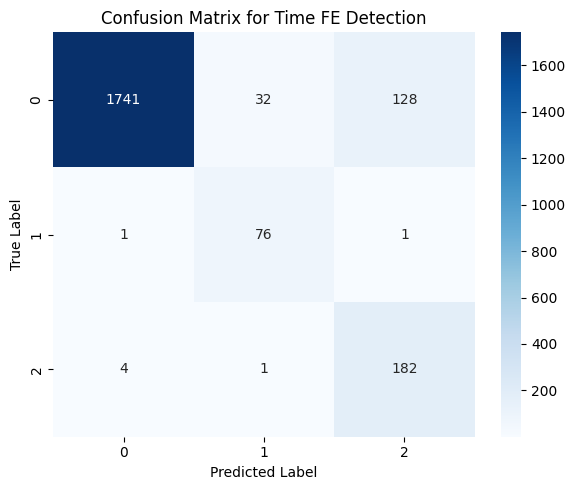

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Time FE Detection')
plt.tight_layout()
plt.show()

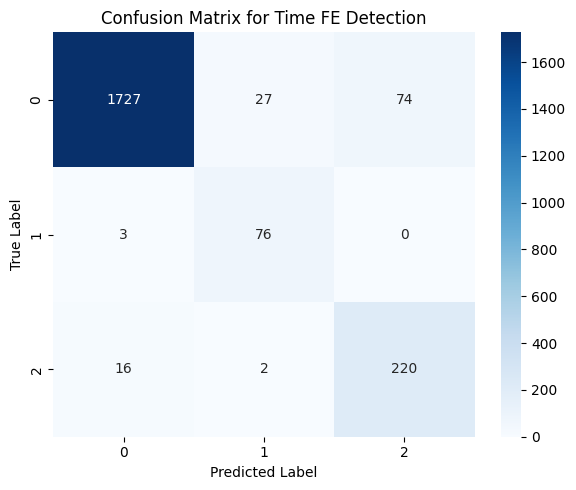

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Time FE Detection')
plt.tight_layout()
plt.show()

-can leverage the nect few labels, in post processing, look to see if the next few are 0 or 1
-make statistics for how many full tokens does it actually get

In [ ]:
import torch
from tqdm import tqdm

def extract_binary_spans(label_seq):
    spans = []
    start = None
    for i, val in enumerate(label_seq):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            spans.append((start, i - 1))
            start = None
    if start is not None:
        spans.append((start, len(label_seq) - 1))
    return spans

def evaluate_binary_predictions(true_labels_list, pred_labels_list):
    strict_match = 0
    partial_match = 0
    total_spans = 0

    for true_seq, pred_seq in zip(true_labels_list, pred_labels_list):
        true_spans = extract_binary_spans(true_seq)
        pred_spans = extract_binary_spans(pred_seq)
        total_spans += len(true_spans)

        for t_start, t_end in true_spans:
            t_range = set(range(t_start, t_end + 1))
            match_found = False
            for p_start, p_end in pred_spans:
                p_range = set(range(p_start, p_end + 1))
                if t_range == p_range:
                    strict_match += 1
                    match_found = True
                    break
                elif t_range & p_range:
                    match_found = True
            if match_found:
                partial_match += 1

    return {
        "Total Time Elements": total_spans,
        "Strict Matches": strict_match,
        "Partial Matches": partial_match,
        "Strict Accuracy": strict_match / total_spans if total_spans > 0 else 0,
        "Partial Accuracy": partial_match / total_spans if total_spans > 0 else 0
    }

# ⬇️ EVALUATION CODE
def evaluate_model(model, val_dataloader, device):
    model.eval()
    true_labels_all = []
    pred_labels_all = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs, dim=-1)  # shape: (B, T)

            for label_seq, pred_seq, mask in zip(labels, predictions, attention_mask):
                # Remove padding (-100) and apply attention mask
                true_seq = [label.item() for label, m in zip(label_seq, mask) if m == 1 and label != -100]
                pred_seq = [pred.item() for pred, m in zip(pred_seq, mask) if m == 1]

                true_labels_all.append(true_seq)
                pred_labels_all.append(pred_seq[:len(true_seq)])  # Match lengths just in case

    return evaluate_binary_predictions(true_labels_all, pred_labels_all)


In [ ]:
def evaluate_model_postprocessed(model, val_dataloader, device):
    model.eval()
    true_labels_all = []
    pred_labels_all = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            raw_preds = torch.argmax(outputs, dim=-1)  # (B, T)
            fixed_preds = fix_bio_predictions(raw_preds)  # Apply post-processing

            for label_seq, pred_seq, mask in zip(labels, fixed_preds, attention_mask):
                # Remove padding and apply attention mask
                true_seq = [label.item() for label, m in zip(label_seq, mask) if m == 1 and label != -100]
                pred_seq = [pred.item() for pred, m in zip(pred_seq, mask) if m == 1]

                # Convert BIO to binary: 1 if B-Time or I-Time, else 0
                true_binary = [1 if tag in (1, 2) else 0 for tag in true_seq]
                pred_binary = [1 if tag in (1, 2) else 0 for tag in pred_seq[:len(true_seq)]]

                true_labels_all.append(true_binary)
                pred_labels_all.append(pred_binary)

    return evaluate_binary_predictions(true_labels_all, pred_labels_all)


In [ ]:
results = evaluate_model_postprocessed(model2, val_dataloader, device)

print("📊 Post-Processed Evaluation Results:")
for k, v in results.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")


  0%|          | 0/902 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 902/902 [03:13<00:00,  4.65it/s]

📊 Post-Processed Evaluation Results:
Total Time Elements: 4592
Strict Matches: 3864
Partial Matches: 4467
Strict Accuracy: 0.841
Partial Accuracy: 0.973


Strict accuracy went from .732 to .841. Partial accuracy went from .894 to .973